In [1]:
#style: make functions! even classes if necessary! funcs for FF reduction for example, etc. to reuse for labs 2 and 3!
#say what functions and key(most) lines/line groups do!
#long descriptions can be in the form of comments if about a specific block
#make graph labels BIG!
#move files to the local jupyter directory, avoiding reference to my name or group

## Data Analysis

(intro description)

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output

### 4.1: Bias Frames

(a description of what I do in 4.1.1 and 4.1.2)

The total number of pixels is 3145728,     since 3 frames have 1048576 pixels
Optimal parameters: [a  mean  stdev] = [6.26560402e+06 1.00373928e+03 7.82107780e+00]


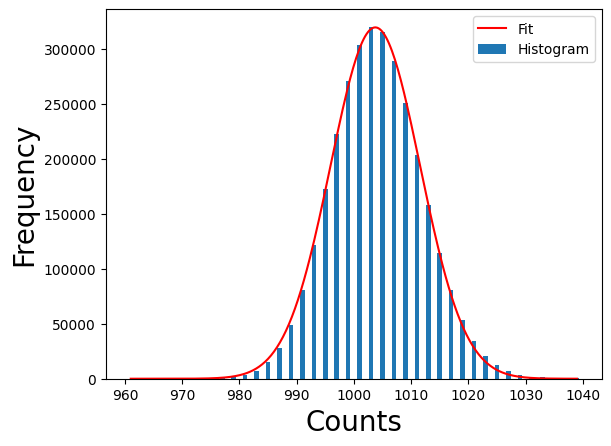

In [3]:
#The following function creates a numpy histogram object given.
#It does so by iterating over the given files, using a context manager 
#and opening each file, reshaping each file to a 1D array, looping over
#this new array, and adding pixel count amounts 1 by 1 to a combining list. 
#The total number of pixels is for the whole camera, not just those being graphed for a given function call.
def fits_list_generate(files): #files is a list of file path strings
    total_pixel_counts_list = []
    for file in files:
        with fits.open(file) as hdu:
            data = hdu[0].data
            data_serialized = np.reshape(data,np.size(data))
            for x in data_serialized:
                total_pixel_counts_list.append(x)
    print(f"The total number of pixels is {len(total_pixel_counts_list)}, \
    since {len(files)} frames have {int(len(total_pixel_counts_list)/len(files))} pixels")
    return total_pixel_counts_list

#A normal distribution, scaled by a constant factor to fit a gaussian distribution 
#to a non-normalized function and still have an easily defined mean and standard 
#deviation.
def scaled_normal_dist(x, a, mean, stdev):
    return a * np.exp(-(x-mean)**2/(2.0*stdev**2)) / np.sqrt(2.0*np.pi*stdev**2)

#graphs the histogram and the gaussian fit for a given pixel counts list, bin number,
#counts range, and creates a bar graph with bars of tunable width (in approximately units of counts, it seems). 
def graph_histogram_gaussian_fit(total_pixel_counts_list,bins,counts_range,width=.8):
    hist = np.histogram(total_pixel_counts_list,bins=bins,range=counts_range)
    hist_x_vals = hist[1][1:] - .5*(hist[1][1]-hist[1][0])
    hist_y_vals= hist[0]
    popt, pcov = curve_fit(scaled_normal_dist, xdata=hist_x_vals, ydata=hist_y_vals, p0=[20,1000,20])
    print(f"Optimal parameters: [a  mean  stdev] = {popt}")
    fig, ax = plt.subplots()
    ax.set_xlabel("Counts",fontsize=20)
    ax.set_ylabel("Frequency",fontsize=20)
    fit_x_vals = np.linspace(hist_x_vals[0],hist_x_vals[-1],300)
    ax.bar(hist_x_vals,hist_y_vals,label='Histogram',width=width)
    ax.plot(fit_x_vals,scaled_normal_dist(fit_x_vals, *popt),'r-',label="Fit")
    ax.legend()

#The three 0C bias fits files
fits_files = ["Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000010.BIAS.FIT",
              "Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000011.BIAS.FIT",
              "Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000012.BIAS.FIT"]

#These values produced a good-looking gaussian fit, where some 
#other combinations would produce much less accurate-seeming results.
graph_histogram_gaussian_fit(fits_list_generate(fits_files),40,[960,1040])

The total number of pixels is 3145728,     since 3 frames have 1048576 pixels
Optimal parameters: [a  mean  stdev] = [  20. 1000.   20.]


C:\Users\tdavd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:499: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


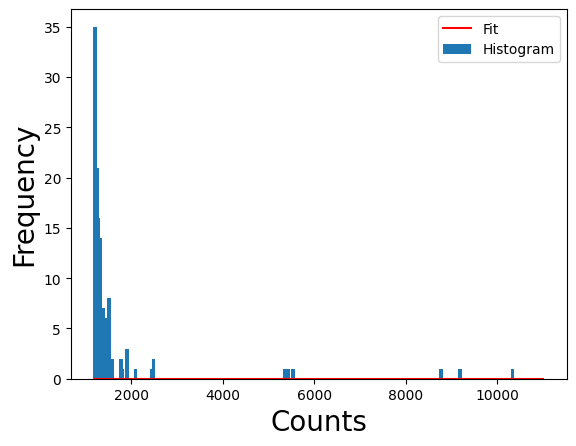

In [4]:
#This block uses the same function as above to search for hot pixels, which is why width and scale are arguments.
#The leftmost spike and its surrounding high density of values is viewed as part of the tail of the Gaussian, with real
#hot pixels only obviously starting around 5000. It is possible that some of the higher pixels on the alleged Gaussian tail
#are warm pixels, but not as obvious. Thus, the cutoff above which pixels are ignored is declared as 5000. Using numpy's
#array methods, it is determined that the rightmost point is the maximum value recorded. Changes to this value can be made to 
#avoid future hot and current warm pixels at the possible expense of some functioning pixels. 
#Note: iven the bounds, we do not expect reasonable parameters; we only want to see pixel counts anyway for this plot.
graph_histogram_gaussian_fit(fits_list_generate(fits_files),300,[1200,11000],width=80)

In [5]:
#From the above, determine fraction of identified hot pixels:
n_hot_pixels = 0
counts_list = fits_list_generate(fits_files)
clear_output() #because we don't need to know how many pixels there are now. It's inelegant and will be fixed later.
for x in counts_list:
    if x > 5000:
        n_hot_pixels += 1
print(f"There are {n_hot_pixels} identified hot pixels, a fraction of {n_hot_pixels/len(counts_list):.7f} of the total.")

There are 6 identified hot pixels, a fraction of 0.0000019 of the total.


In [6]:
#This block prints the headers of one of the bias fits files.
#According to the CCD datasheet, gain = 2., readout noise 14.8e- RMS. Gain agrees to within 3% with header
with fits.open("Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000010.BIAS.FIT") as hdu:
            print(hdu[0].header)

print('\n', f"The readout noise from our data is {2.06*7.82:.1f} e-, which is {100.*(2.06*7.82-14.8)/(14.8):.2f}% away from the datasheet value.")

SIMPLE  =                    T/CCDSOFT-SOFTWARE BISQUE 3                        BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  BSCALE  = +1.000000000000E+000                                                  BZERO   = +3.276800000000E+004                                                  BIAS    =                  100                                                  FOCALLEN= +0.000000000000E+000                                                  APTAREA = +0.000000000000E+000                                                  APTDIA  = +0.000000000000E+000                                                  DATE-OBS= '2024-08-30T01:57:32.328'                                             TIME-OBS= '01:57:32.328        '        

### 4.2 (Anthony)

In [ ]:
#This creates a list of all FITS files that will be used.
folder_path = r'C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure'
file_number = 0
file_name = '\dark_0.3s_exposure_.0000000' + str(file_number) + '.DARK.FIT'
file_list = []
num_of_files = 10

i=0
while i < num_of_files:
    file_name = '\dark_0.3s_exposure_.0000000' + str(i) + '.DARK.FIT'
    file_list.append(folder_path + file_name)
    i = i + 1

for file in file_list: print(file) #View file list

In [ ]:
#4.2.1 functions
def median_combine(pixel_counts_array):
    master_dark_frame_array = np.zeros(len(pixel_counts_array))
    for row in range(pixel_counts_array.shape[0]):
        master_dark_frame_array[row] = np.median(pixel_counts_array[row, :]) 
    print('master_dark_frame_array Shape:',master_dark_frame_array.shape)
    print('master_dark_frame_array Size:',master_dark_frame_array.size)
    return master_dark_frame_array

def median_combine(pixel_counts_array):
    master_dark_frame_array = np.zeros(len(pixel_counts_array))
    for row in range(pixel_counts_array.shape[0]):
        master_dark_frame_array[row] = np.median(pixel_counts_array[row, :]) 
    print('master_dark_frame_array Shape:',master_dark_frame_array.shape)
    print('master_dark_frame_array Size:',master_dark_frame_array.size)
    return master_dark_frame_array

def fits_data_to_1d_array(file_list):  #Actually you can just do    array.flatten()   but which is quicker?
    pixel_counts_array_1d = []
    for file in file_list:
        with fits.open(file) as hdu:
            data = hdu[0].data
            data_serialized = np.reshape(data,np.size(data))
            pixel_counts_array_1d = np.append(pixel_counts_array_1d, data_serialized)
    print('pixel_counts_array_1d Shape:',pixel_counts_array_1d.shape)
    print('pixel_counts_array_1d Size:',pixel_counts_array_1d.size)
    return pixel_counts_array_1d

def hot_pixel_identifier(pixel_counts_array):
    arr_shape = np.shape(pixel_counts_array)
    hot_pixel_array = np.zeros((int(arr_shape[0]), int(arr_shape[1])))
    for (i,j), value in np.ndenumerate(pixel_counts_array):
        if value >= 2000: hot_pixel_array[i,j] = 1         #THRESHOLD!!
    print(np.shape(hot_pixel_array))
    return hot_pixel_array

def hot_pixel_array_sum_rows(hot_pixel_array):
    raw_data_shape = shape_of_raw_data(file_list)
    hot_pixels_1d = np.zeros(len(hot_pixel_array))    
    for row in range(hot_pixel_array.shape[0]): 
        hot_pixels_1d[row] = np.sum(hot_pixel_array[row])
        if hot_pixels_1d[row] > 0: 
            print('Hot pixel in row ', row)
            print('Location:', np.unravel_index(row, raw_data_shape))
    return hot_pixels_1d

def shape_of_raw_data(file_list):  
    for file in file_list:
        with fits.open(file) as hdu:
            data = hdu[0].data
            return(np.shape(data))

In [ ]:
#Stores data from images into a 2-dim array:
pixel_counts_array = fits_data_to_2d_array(file_list)
#Performs a median combine to get a master dark frame:
master_dark_frame_array = median_combine(pixel_counts_array)

In [ ]:
#Save to .csv to view manually
np.savetxt("pixel_counts_array.csv", pixel_counts_array, delimiter = ",", fmt='%d')
np.savetxt("master_dark_frame.csv", master_dark_frame_array, delimiter = ",", fmt='%d')

In [ ]:
                                   #Identifying Hot Pixels
#Plot histogram to see distribution:
graph_histogram_gaussian_fit(pixel_counts_array.flatten(),40,[960,1040], width=.5)
#Plot another to see where some hot pixels may be
graph_histogram_gaussian_fit(pixel_counts_array.flatten(),300,[1200,11000],width=80)

In [ ]:
                                   #Identifying Hot Pixels Cont...
#Threshold used: 2000 counts

#The following creates an array (with the same shape as the input) filled with zeros except for the
#pixels that are above the threshhold - they are given a value equal to 1.
hot_pixel_array = hot_pixel_identifier(pixel_counts_array)
np.savetxt("hot_pixel_array.csv", hot_pixel_array, delimiter=",", fmt='%d') #For manual viewing
print('Number of hot pixels: ', np.sum(hot_pixel_array).flatten())

#The following creates an 1d array out of the hot pixels array that stores the sum of each row.
#The purpose of this is to see if the identified hot pixels are "hot" for all images. 
hot_pixel_rows_summed = hot_pixel_array_sum_rows(hot_pixel_array)
print('Number of hot pixels: ', np.sum(hot_pixel_rows_summed)) #Double check sum
np.savetxt("hot_pixel_rows_summed.csv", hot_pixel_rows_summed, delimiter=",", fmt='%d')

In [ ]:
#Gauge Middle Value for Counts, and other statistics
median = np.median(pixel_counts_array)
mean = pixel_counts_array.mean()
minimum = np.min(pixel_counts_array)
maximum = np.max(pixel_counts_array)
print('median: ', median, 'mean: ', mean, 'min: ', minimum, 'max: ', maximum)
max_index = np.argmax(pixel_counts_array)
print(max_index)